In [15]:
%matplotlib inline
from pandas import Series

# 1a

### 1b. Use the data from three diploids at https://dorman.stat.iastate.edu/files/genotyping.txt to compute the likelihood of the data in individual 0 at sites 962 and 964 assuming the reference base in both cases is $n_{b}$ = A. What are your maximum likelihood estimates $\hat{G}_{MLE,962}$ and $\hat{G}_{MLE,964}$ of the genotypes? (These data are unforgivingly huge, so you may want to do selective reading of the data in some smart way.)


### Genotyping.txt

<ol>
    <li>Id of individual</li>
    <li>Id of read</li>
    <li>Reference position</li>
    <li>Read base call</li>
    <li>Read quality score</li>
</ol>


In [11]:
%%bash
awk '($1==0 && $3==962 && $4!="NA") {print $0}' genotyping.txt >Individual0_position962.txt # The first position we are asked to compute for individual 0
awk '($1==0 && $3==964 && $4!="NA") {print $0}' genotyping.txt >Individual0_position964.txt # The second position we are asked to compute for individual 0
echo "Coverage for position 962:"; wc -l Individual0_position962.txt
echo "Coverage for position 964:"; wc -l Individual0_position964.txt; echo
head Individual0_position962.txt

Coverage for position 962:
    8883 Individual0_position962.txt
Coverage for position 964:
    8886 Individual0_position964.txt

0 0 962 A p
0 1 962 A h
0 2 962 A i
0 3 962 A l
0 4 962 G X
0 5 962 G p
0 6 962 G p
0 7 962 A p
0 8 962 A p
0 9 962 G r


In [50]:
fh = open("Pos962_data.txt","w")
fh.write("i\tj\tq\ta\n")
nRead = 0
for read in positions[0]: 
    nRead +=1
    fh.write("0\t%i\t%i\t%i\n" % (nRead,read.q,int(read.call == 'A')))
fh.close()
    

In [51]:
%%bash
head Pos962_data.txt

i	j	q	a
0	1	112	1
0	2	104	1
0	3	105	1
0	4	108	1
0	5	112	1
0	6	112	1
0	7	113	1
0	8	108	1
0	9	104	1


In [12]:
class SeqRead:
    def __init__(self,data):
        rec = data.strip().split()
        self.q = ord(rec[4])
        self.call = rec[3]

In [13]:
pos962,pos964 = [],[]
for line in open("Individual0_position962.txt"): pos962.append(SeqRead(line))
for line in open("Individual0_position964.txt"): pos964.append(SeqRead(line))

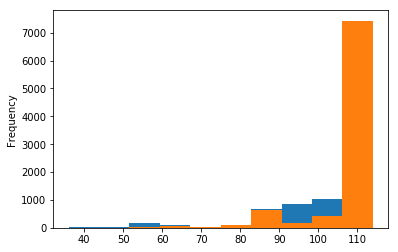

In [16]:
from pandas import Series
positions = [pos962,pos964]
for pos in positions:
    qscores = []
    for read in pos:qscores.append(read.q)
    qscores = Series(qscores)
    qscores.plot.hist()

In [17]:
print qscores.describe()

count    8886.000000
mean      108.660027
std         9.702624
min        36.000000
25%       110.000000
50%       113.000000
75%       113.000000
max       114.000000
dtype: float64


In [22]:
# Sort by call
positions[0].sort(key=lambda x:x.call)
positions[1].sort(key=lambda x:x.call)

In [28]:
from collections import Counter

for pos in positions:
    counter = {}
    for read in pos:
        try:counter[read.call] +=1
        except:counter[read.call] = 1
    print counter

{'A': 4044, 'C': 3, 'T': 9, 'G': 4827}
{'A': 3742, 'C': 5135, 'T': 5, 'G': 4}


In [33]:
%R

install.packages('dplyr')
#library(dplyr, quietly = T, warn.conflicts = F)

#g - 1
#a - 
#m - diploid m=2
#e - quality score
#k - # of reference Alleles

#L(D=d_i | G=g)
log.likelihood.d.g <- function(g, a, m, e, k)
{ 
    -k*log(m) +
    sum( log(ifelse(a == 1,
        (m - g) * e/3 + g * (1 - e), 
        (m - g) * (1 - e) + g * e/3 )))
}

ERROR:root:Line magic function `%R` not found.


NameError: name 'install' is not defined

In [ ]:
log.likelihood.G <- function(d, m=2)
{ 
    do.call(rbind,
        lapply(split(d, factor(d$i)), function(d_i){ 
            sapply(0:m, log.likelihood.d.g, a=d_i$a,
            m=m, e=d_i$e, k=nrow(d_i))
        })
    )
}
